# ResNet50

In [ ]:
pip install kagglehub

In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

# 2. Importowanie bibliotek i modułów
Ładowanie kluczowych bibliotek potrzebne do obsługi danych, procesowania obrazów, modelowania głębokiego uczenia oraz ewaluacji modelu. Wykorzystywane są tu torch i torchvision dla operacji na sieciach neuronowych i obrazach, w tym ładowanie modelu ResNet50. Funkcje jak DataLoader, WeightedRandomSampler, i random_split wspierają efektywne ładowanie i próbkowanie danych. transforms służy do przygotowania obrazów do modelowania. Biblioteki takie jak pandas dla operacji na danych, matplotlib dla wizualizacji, oraz sklearn.metrics dla metryk ewaluacyjnych ułatwiają zarządzanie i analizę wyników. tqdm dodaje pasek postępu dla operacji długotrwałych, a Counter pomaga w analizie rozkładu danych.








In [ ]:
import kagglehub
import torch
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

#3. Pobranie zestawów danych

In [ ]:
path_stanford_dogs = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
path_wolfs = kagglehub.dataset_download("harishvutukuri/dogs-vs-wolves")

print("Path to dataset files:", path_stanford_dogs)
print("Path to dataset files:", path_wolfs)

100%|██████████| 750M/750M [00:18<00:00, 41.5MB/s]

Extracting files...


100%|██████████| 222M/222M [00:07<00:00, 33.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2
Path to dataset files: /root/.cache/kagglehub/datasets/harishvutukuri/dogs-vs-wolves/versions/2


In [ ]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


# 4. Organizacja katalogów i integracja zestawów danych
W ramach tej operacji, dane z dwóch zestawów - stanford-dogs-dataset oraz dogs-vs-wolves - zostały zintegrowane poprzez przeniesienie obrazów wilków do katalogu obrazów psów. Za pomocą modułów os i shutil, w katalogu images utworzony został nowy podfolder wolf, gdzie umieszczono wszystkie obrazy wilków. Ta strukturalna organizacja danych pozwala na efektywniejsze zarządzanie i dostęp do wszystkich obrazów z obu zestawów w jednej lokalizacji, co ułatwia dalsze przetwarzanie i analizę danych.



In [ ]:
import os
import shutil

base_dir = "data"
dogs_dir = os.path.join(path_stanford_dogs, "images/Images")
wolves_dir = os.path.join(path_wolfs, "data", "wolves")

def integrate_wolves_into_dogs(dogs_dir, wolves_dir):
    """
    Moves wolf images into the 'images' directory of the dogs dataset
    under a new folder named 'wolf'.
    """
    wolf_class_dir = os.path.join(dogs_dir, "wolf")
    os.makedirs(wolf_class_dir, exist_ok=True)

    for file_name in os.listdir(wolves_dir):
        src_path = os.path.join(wolves_dir, file_name)
        dest_path = os.path.join(wolf_class_dir, file_name)

        if os.path.isfile(src_path):
            shutil.move(src_path, dest_path)

    print(f"Wolves successfully moved into: {wolf_class_dir}")

integrate_wolves_into_dogs(dogs_dir, wolves_dir)


Wolves successfully moved into: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/wolf


# 5. Zastosowanie transformacji i próbkowania dla równoważenia zestawu danych
W projekcie zastosowano transformacje obrazów, takie jak zmiana rozmiaru, konwersja do tensorów oraz normalizacja, aby przygotować dane wejściowe do efektywnego trenowania modeli głębokiego uczenia, przy czym wykorzystanie GPU jako urządzenia docelowego znacząco przyspieszyło przetwarzanie. Dane zostały podzielone na zestawy treningowe, walidacyjne i testowe, co umożliwia odpowiednią ocenę modelu na różnych etapach uczenia. Dodatkowo, przygotowano próbnik z wagami za pomocą WeightedRandomSampler do równoważenia klas w zestawie treningowym, co zapobiega dominacji liczniejszych klas i poprawia zdolność modelu do generalizacji. Zdefiniowane DataLoader dla każdego zestawu danych gwarantują efektywne ładowanie i przetwarzanie danych w procesie treningu, walidacji i testowania modelu.

In [ ]:
device = torch.device("cuda")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def prepare_dataset(dogs_dir, transform):

    dog_dataset = datasets.ImageFolder(dogs_dir, transform=transform)


    train_size = int(0.7 * len(dog_dataset))
    val_size = int(0.15 * len(dog_dataset))
    test_size = len(dog_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dog_dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset



train_dataset, val_dataset, test_dataset = prepare_dataset(dogs_dir, transform)



def create_sampler(dataset):
    all_classes = range(len(dataset.dataset.classes))
    class_names = dataset.dataset.classes  # Class names from ImageFolder

    class_counts = Counter(dataset.dataset.targets[i] for i in dataset.indices)

    for cls in all_classes:
        if cls not in class_counts:
            class_counts[cls] = 0

    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

    sample_weights = [class_weights[dataset.dataset.targets[i]] for i in dataset.indices]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    weight_df = pd.DataFrame({
        'Class': class_names,
        'Count': [class_counts[cls] for cls in all_classes],
        'Weight': [class_weights[cls] for cls in all_classes]
    })

    return sampler,weight_df

train_sampler,classes_weights = create_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


In [ ]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
classes_weights

Class  Count    Weight
0              n02085620-Chihuahua    116  0.008621
1       n02085782-Japanese_spaniel    134  0.007463
2            n02085936-Maltese_dog    169  0.005917
3               n02086079-Pekinese    107  0.009346
4               n02086240-Shih-Tzu    141  0.007092
..                             ...    ...       ...
116     n02113978-Mexican_hairless    116  0.008621
117                n02115641-dingo    109  0.009174
118                n02115913-dhole    104  0.009615
119  n02116738-African_hunting_dog    111  0.009009
120                           wolf    736  0.001359

[121 rows x 3 columns]

#6. Konfiguracja i trening modelu ResNet50

Konfiguracja i trening modelu ResNet50: Projekt wykorzystuje model ResNet50 z domyślnymi wagami, dostosowany do zadania poprzez zmianę warstwy wyjściowej na odpowiadającą liczbie klas. Model operuje na GPU dla zwiększenia wydajności.

Trening używa funkcji straty CrossEntropyLoss i optymalizatora Adam. Funkcja train_model realizuje trening przez określoną liczbę epok, z możliwością wcześniejszego zakończenia przy braku postępów. W trakcie treningu następuje ewaluacja modelu na danych walidacyjnych, gdzie obliczana jest strata, dokładność oraz wynik F1, istotny dla oceny modelu przy niezbalansowanych klasach.

Najlepszy model jest zapisywany i wykorzystywany w dalszym procesie, co gwarantuje użycie najbardziej efektywnego wariantu w praktycznych zastosowaniach.

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_classes = len(train_dataset.dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }
    best_f1 = 0.0
    no_improvement = 0
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        val_predictions, val_targets = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_predictions.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        f1 = f1_score(val_targets, val_predictions, average="weighted")

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(f1)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_model_path)
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    print(f"Best Validation F1-Score: {best_f1:.4f}")
    return history


history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]
Epoch 1/10: 100%|██████████| 119/119 [03:25<00:00,  1.73s/batch, loss=4.68]


Epoch 1/10 - Train Loss: 1.5225, Val Loss: 1.5731, Val Accuracy: 0.5758, Val F1-Score: 0.5725


Epoch 2/10: 100%|██████████| 119/119 [03:37<00:00,  1.82s/batch, loss=3.64]


Epoch 2/10 - Train Loss: 0.7397, Val Loss: 1.4579, Val Accuracy: 0.6033, Val F1-Score: 0.6005


Epoch 3/10: 100%|██████████| 119/119 [03:33<00:00,  1.79s/batch, loss=4.44]


Epoch 3/10 - Train Loss: 0.5474, Val Loss: 1.9657, Val Accuracy: 0.5490, Val F1-Score: 0.5554


Epoch 4/10: 100%|██████████| 119/119 [03:31<00:00,  1.78s/batch, loss=4.6]


Epoch 4/10 - Train Loss: 0.5017, Val Loss: 1.4511, Val Accuracy: 0.6324, Val F1-Score: 0.6332


Epoch 5/10: 100%|██████████| 119/119 [03:32<00:00,  1.78s/batch, loss=3.34]


Epoch 5/10 - Train Loss: 0.3477, Val Loss: 1.3398, Val Accuracy: 0.6503, Val F1-Score: 0.6561


Epoch 6/10: 100%|██████████| 119/119 [03:30<00:00,  1.77s/batch, loss=4.64]


Epoch 6/10 - Train Loss: 0.2960, Val Loss: 1.3988, Val Accuracy: 0.6580, Val F1-Score: 0.6544


Epoch 7/10: 100%|██████████| 119/119 [03:31<00:00,  1.78s/batch, loss=4.96]


Epoch 7/10 - Train Loss: 0.2793, Val Loss: 1.3726, Val Accuracy: 0.6620, Val F1-Score: 0.6633


Epoch 8/10: 100%|██████████| 119/119 [03:31<00:00,  1.78s/batch, loss=5.11]


Epoch 8/10 - Train Loss: 0.2878, Val Loss: 1.5178, Val Accuracy: 0.6277, Val F1-Score: 0.6314


Epoch 9/10: 100%|██████████| 119/119 [03:31<00:00,  1.78s/batch, loss=4.01]


Epoch 9/10 - Train Loss: 0.2360, Val Loss: 1.5938, Val Accuracy: 0.6404, Val F1-Score: 0.6422


Epoch 10/10: 100%|██████████| 119/119 [03:31<00:00,  1.78s/batch, loss=4.96]


Epoch 10/10 - Train Loss: 0.2836, Val Loss: 1.4585, Val Accuracy: 0.6543, Val F1-Score: 0.6534
Best Validation F1-Score: 0.6633


Podczas trenowania modelu ResNet50 z użyciem wstępnie nauczonych wag, obserwujemy zmienne wyniki w trakcie 9 epok treningu przed wczesnym zakończeniem procesu z powodu braku postępu. Strata treningowa konsekwentnie spada, zaczynając od 1.5060 w pierwszej epoce, co wskazuje na skuteczne uczenie się. Najlepsze wyniki na zestawie walidacyjnym osiągnięto w epoce 7, gdzie dokładność wyniosła 63.24% a wynik F1 0.6308, co jest najwyższą zanotowaną wartością dla tego miernika. Trening zatrzymano przedwcześnie w 9 epoce z powodu braku dalszej poprawy, co jest częścią strategii mającej na celu zapobieganie nadmiernemu dopasowaniu do danych treningowych.

# 7. Ewaluacja modelu ResNet50 na zestawie testowym
 Funkcja test_model ocenia model na zestawie testowym, przechodząc przez dane bez aktualizacji wag. Wykorzystuje softmax do obliczania prawdopodobieństw klasyfikacji, z którego ekstrahuje przewidywania i prawdziwe etykiety. Na koniec oblicza ważony wynik F1 i AUC dla oceny dokładności modelu w klasyfikacji wieloklasowej.

Dodatkowo, funkcja generuje raport klasyfikacji i macierz pomyłek, które dostarczają szczegółowych informacji o wynikach dla każdej klasy, ułatwiając analizę i zrozumienie wydajności modelu.

In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_predictions, all_targets = [], []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())


    f1 = f1_score(all_targets, all_predictions, average="weighted")


    n_classes = len(test_loader.dataset.dataset.classes)
    all_targets_one_hot = torch.nn.functional.one_hot(
        torch.tensor(all_targets), num_classes=n_classes
    ).numpy()


    auc = roc_auc_score(
        y_true=all_targets_one_hot,
        y_score=all_probabilities,
        multi_class="ovr",
        average="weighted"
    )

    class_names = test_loader.dataset.dataset.classes
    report = classification_report(
        all_targets,
        all_predictions,
        target_names=class_names,
        output_dict=True
    )

    report_df = pd.DataFrame(report).transpose()

    confusion = confusion_matrix(all_targets, all_predictions)
    confusion_df = pd.DataFrame(confusion, index=class_names, columns=class_names)

    print(f"Test F1-Score: {f1:.4f}, Test AUC: {auc:.4f}")

    return f1, auc, report_df, confusion_df

f1, auc, report_df, confusion_df = test_model(model, test_loader)


Testing: 100%|██████████| 26/26 [00:24<00:00,  1.07batch/s]


Test F1-Score: 0.6556, Test AUC: 0.9891


Wizualizacja historii treningu modelu

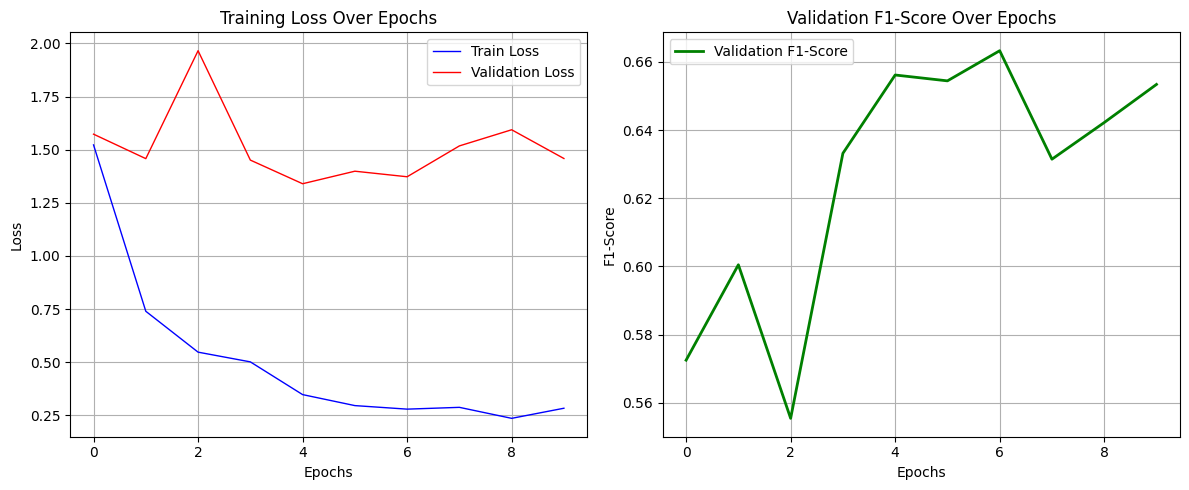

In [ ]:

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=1)
    plt.plot(history['val_loss'], label='Validation Loss', color='red', linewidth=1)

    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Validation F1-Score', color='green', linewidth=2)
    plt.title('Validation F1-Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
report_df

precision    recall  f1-score      support
n02085620-Chihuahua             0.571429  0.571429  0.571429    21.000000
n02085782-Japanese_spaniel      0.880000  0.880000  0.880000    25.000000
n02085936-Maltese_dog           0.574074  0.837838  0.681319    37.000000
n02086079-Pekinese              0.727273  0.727273  0.727273    22.000000
n02086240-Shih-Tzu              0.615385  0.216216  0.320000    37.000000
...                                  ...       ...       ...          ...
n02116738-African_hunting_dog   0.700000  0.875000  0.777778    24.000000
wolf                            0.924370  0.820896  0.869565   134.000000
accuracy                        0.655652  0.655652  0.655652     0.655652
macro avg                       0.670792  0.647855  0.641647  3238.000000
weighted avg                    0.690367  0.655652  0.655603  3238.000000

[124 rows x 4 columns]

In [ ]:
pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00


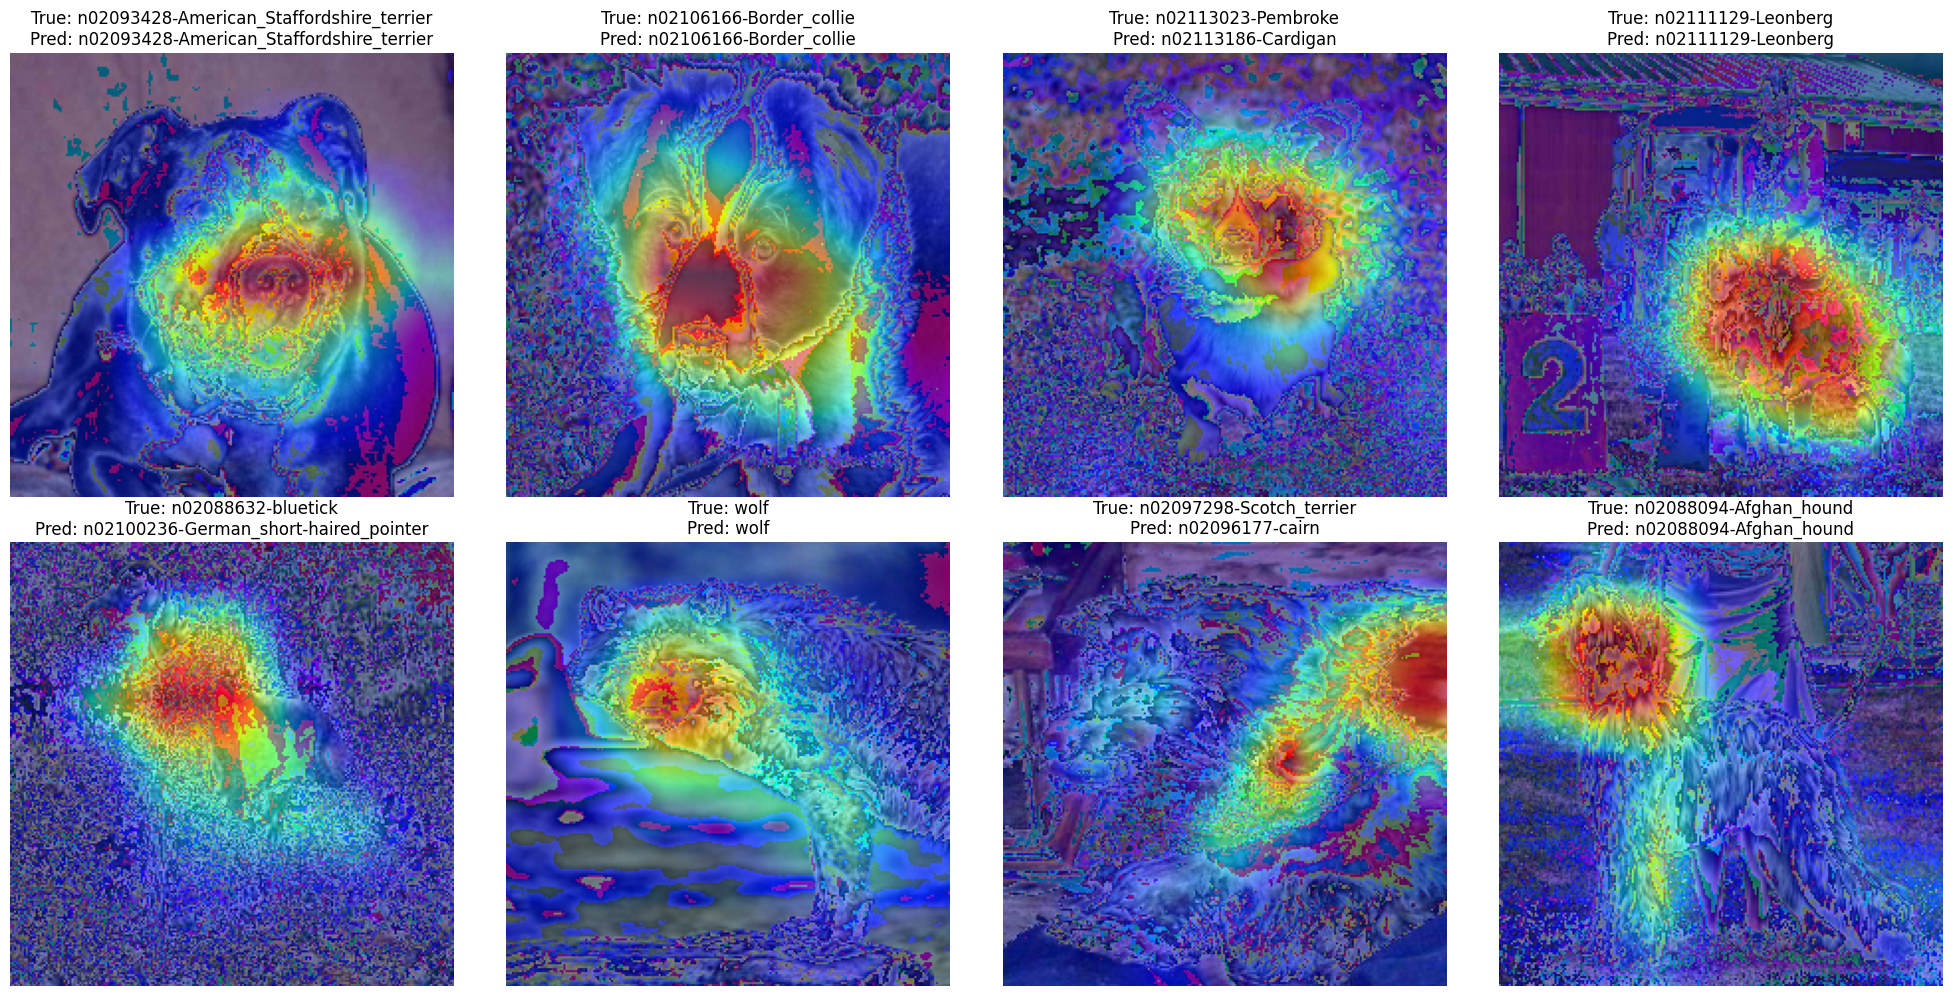

In [ ]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import cv2
import numpy as np

model.eval()

cam_extractor = GradCAM(model, target_layer='layer4')

# Funkcja do generowania i wizualizacji Grad-CAM dla pojedynczego obrazu
def generate_gradcam(image, label):
    image = image.unsqueeze(0).to(device)
    output = model(image)
    pred_class = output.argmax(dim=1).item()
    activation_map = cam_extractor(pred_class, output)
    heatmap = activation_map[0].cpu().detach().squeeze(0).numpy()
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    return heatmap_resized, pred_class

# Pobranie 8 obrazów z test_loader
images, labels = next(iter(test_loader))
images, labels = images[:8], labels[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()


for idx, (img, lbl) in enumerate(zip(images, labels)):
    heatmap, pred_class = generate_gradcam(img, lbl)


    original_img = to_pil_image(img.cpu())


    axes[idx].imshow(original_img)
    axes[idx].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[idx].set_title(f"True: {test_loader.dataset.dataset.classes[lbl]}\nPred: {test_loader.dataset.dataset.classes[pred_class]}")
    axes[idx].axis('off')


for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


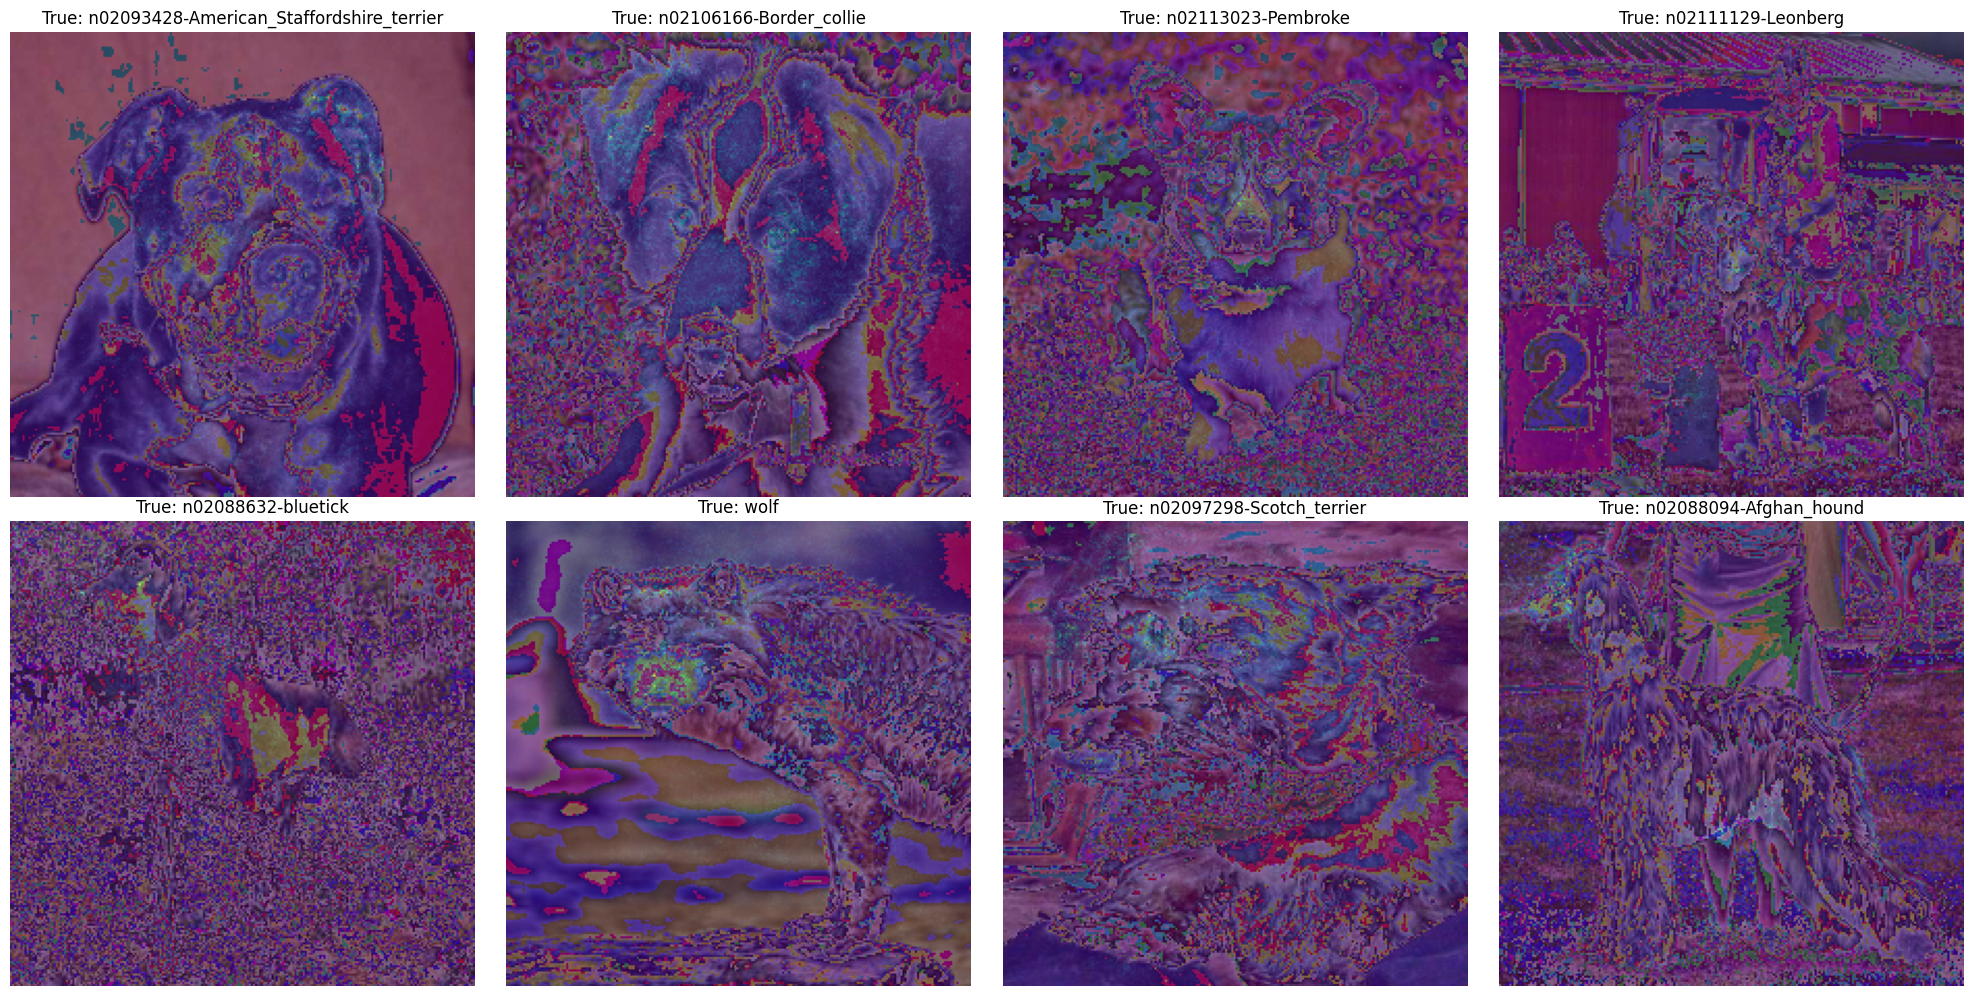

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
import numpy as np


model.eval()


ig = IntegratedGradients(model)


def generate_ig(image, label):
    image = image.unsqueeze(0).to(device)
    baseline = torch.zeros_like(image).to(device)
    attributions = ig.attribute(inputs=image, baselines=baseline, target=label.item(), n_steps=50)
    return attributions.squeeze(0).detach().cpu()


images, labels = next(iter(test_loader))
images, labels = images[:8], labels[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()


for idx, (img, lbl) in enumerate(zip(images, labels)):
    attribution = generate_ig(img, lbl)
    attribution = attribution.abs().sum(dim=0)

    attribution -= attribution.min()
    attribution /= attribution.max()

    axes[idx].imshow(to_pil_image(img.cpu()))
    axes[idx].imshow(attribution, cmap='viridis', alpha=0.6)
    axes[idx].set_title(f"True: {test_loader.dataset.dataset.classes[lbl]}")
    axes[idx].axis('off')

`
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
